In [5]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm

Load image and masks


In [6]:
images_dir = f"Kvasir-SEG/images"
masks_dir = f"Kvasir-SEG/masks"

images = os.listdir(images_dir)
masks = os.listdir(masks_dir)

print(images[0])
print(masks[0])



cju0qkwl35piu0993l0dewei2.jpg
cju0qkwl35piu0993l0dewei2.jpg


In [7]:
def load_image_and_mask(image_path,mask_path):
    image_size = (256,256)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,image_size)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask,image_size)
    mask = np.expand_dims(mask,axis=-1)
    mask = np.where(mask>0,1,0).astype(np.float32)

    return img,mask

In [8]:
def load_dataset(image_paths,mask_paths):
    imgs = []
    masks = []
    for i,m in zip(image_paths,mask_paths):
        img,mask  = load_image_and_mask(i,m)
        imgs.append(img)
        masks.append(mask)

    return np.array(imgs),np.array(masks)

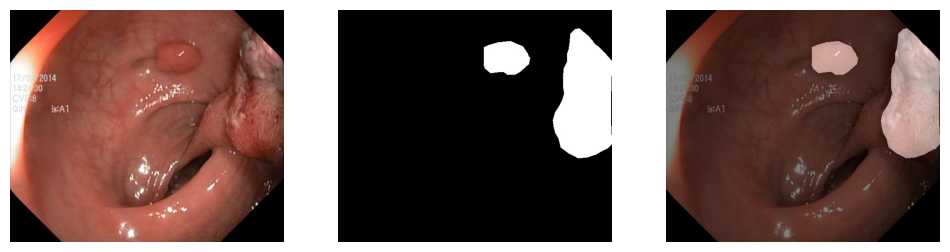

In [9]:
img_p = r"Kvasir-SEG/images/cju0roawvklrq0799vmjorwfv.jpg"
msk_p = r"Kvasir-SEG/masks/cju0roawvklrq0799vmjorwfv.jpg"
img = cv2.imread(img_p)
msk = cv2.imread(msk_p,cv2.IMREAD_GRAYSCALE)
plt.figure(figsize= (12,15))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(msk, cv2.COLOR_BGR2RGB),alpha = 0.5)
plt.axis("off")

plt.show()

In [10]:
images_paths = [os.path.join(images_dir,f) for f in os.listdir(images_dir)]
masks_paths = [os.path.join(masks_dir,f) for f in os.listdir(masks_dir)]

In [7]:
len(images_paths)

1000

In [11]:
len(masks_paths)

1000

In [12]:
images,masks = load_dataset(images_paths,masks_paths)

In [13]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

In [14]:
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]      # (H, W, 3)
        mask = self.masks[idx]        # (H, W, 1)

        # Chuyển sang (C, H, W) và tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask = torch.from_numpy(mask).permute(2, 0, 1).float()

        return image, mask

# Tạo DataLoader
train_loader = DataLoader(SegmentationDataset(train_imgs, train_masks), batch_size=16, shuffle=True)
val_loader = DataLoader(SegmentationDataset(val_imgs, val_masks), batch_size=16, shuffle=False)

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # 'same' padding
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = ConvBlock(3, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.enc5 = ConvBlock(256, 512)
        self.pool5 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec6 = ConvBlock(1024, 512)

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec7 = ConvBlock(512, 256)

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec8 = ConvBlock(256, 128)

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec9 = ConvBlock(128, 64)

        self.up10 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec10 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.out_conv = nn.Conv2d(16, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        e5 = self.enc5(self.pool4(e4))
        b = self.bottleneck(self.pool5(e5))

        # Decoder
        d6 = self.up6(b)
        d6 = self.dec6(torch.cat([d6, e5], dim=1))

        d7 = self.up7(d6)
        d7 = self.dec7(torch.cat([d7, e4], dim=1))

        d8 = self.up8(d7)
        d8 = self.dec8(torch.cat([d8, e3], dim=1))

        d9 = self.up9(d8)
        d9 = self.dec9(torch.cat([d9, e2], dim=1))

        d10 = self.up10(d9)
        d10 = self.dec10(torch.cat([d10, e1], dim=1))

        out = self.sigmoid(self.out_conv(d10))
        return out

In [16]:
model = UNet()
print(model)

UNet(
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool

In [17]:
def dice_coef(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    return (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)

def iou_coef(preds, targets, smooth=1e-6):
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    return (intersection + smooth) / (union + smooth)

In [15]:
def train_model(model, train_loader, val_loader, num_epochs, device):
    best_val_acc = 0.0
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-7)

    # Tạo folder checkpoints nếu chưa có
    os.makedirs("checkpoints4", exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        dice_total = 0.0
        iou_total = 0.0

        for inputs, masks in train_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == masks).sum().item()
            total += masks.numel()

            dice_total += dice_coef(preds, masks).item()
            iou_total += iou_coef(preds, masks).item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_dice = dice_total / len(train_loader)
        train_iou = iou_total / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        dice_total = 0.0
        iou_total = 0.0

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * inputs.size(0)

                preds = (outputs > 0.5).float()
                correct += (preds == masks).sum().item()
                total += masks.numel()

                dice_total += dice_coef(preds, masks).item()
                iou_total += iou_coef(preds, masks).item()

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total
        val_dice = dice_total / len(val_loader)
        val_iou = iou_total / len(val_loader)

        # Scheduler
        scheduler.step(val_loss)

        # Checkpoint
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            ckpt_path = f"checkpoints4/U-Net_epoch{epoch+1}_valacc{val_acc:.4f}.pth"
            torch.save(model.state_dict(), ckpt_path)
            print(f"✅ Saved best model at epoch {epoch+1} to {ckpt_path}")

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Acc: {train_acc:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f} | Loss: {train_loss:.4f} || "
              f"Val Acc: {val_acc:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f} | Loss: {val_loss:.4f}")


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNet(
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_model(model, train_loader, val_loader, num_epochs=25, device=device)

✅ Saved best model at epoch 1 to checkpoints4/U-Net_epoch1_valacc0.8244.pth
Epoch [1/25] - Train Acc: 0.8093 | Dice: 0.1391 | IoU: 0.0790 | Loss: 0.8458 || Val Acc: 0.8244 | Dice: 0.1694 | IoU: 0.0941 | Loss: 0.8270
✅ Saved best model at epoch 2 to checkpoints4/U-Net_epoch2_valacc0.8346.pth
Epoch [2/25] - Train Acc: 0.8427 | Dice: 0.0938 | IoU: 0.0500 | Loss: 0.8016 || Val Acc: 0.8346 | Dice: 0.1972 | IoU: 0.1112 | Loss: 0.7859
✅ Saved best model at epoch 3 to checkpoints4/U-Net_epoch3_valacc0.8405.pth
Epoch [3/25] - Train Acc: 0.8469 | Dice: 0.1394 | IoU: 0.0765 | Loss: 0.7675 || Val Acc: 0.8405 | Dice: 0.4114 | IoU: 0.2611 | Loss: 0.7576
✅ Saved best model at epoch 4 to checkpoints4/U-Net_epoch4_valacc0.8657.pth
Epoch [4/25] - Train Acc: 0.8606 | Dice: 0.3169 | IoU: 0.1910 | Loss: 0.7384 || Val Acc: 0.8657 | Dice: 0.4566 | IoU: 0.2980 | Loss: 0.7397
Epoch [5/25] - Train Acc: 0.8674 | Dice: 0.3814 | IoU: 0.2380 | Loss: 0.7201 || Val Acc: 0.8580 | Dice: 0.3133 | IoU: 0.1874 | Loss: 0.7

In [19]:
model.load_state_dict(torch.load("checkpoints4/U-Net_epoch25_valacc0.9163.pth"))  # thay tên file nếu khác
model.to(device)
model.eval()

UNet(
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool

In [20]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0
    total_dice = 0.0
    total_iou = 0.0
    criterion = nn.BCEWithLogitsLoss()
    n_batches = 0

    with torch.no_grad():
        for inputs, masks in dataloader:
            inputs = inputs.to(device)
            masks = masks.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            total_loss += loss.item() * inputs.size(0)

            preds = (outputs > 0.5).float()
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()

            total_dice += dice_coef(preds, masks).item()
            total_iou += iou_coef(preds, masks).item()
            n_batches += 1

    avg_loss = total_loss / len(dataloader.dataset)
    avg_acc = total_correct / total_pixels
    avg_dice = total_dice / n_batches
    avg_iou = total_iou / n_batches

    print(f"📊 Evaluation Results:")
    print(f"  🔹 Loss       : {avg_loss:.4f}")
    print(f"  🔹 Accuracy   : {avg_acc:.4f}")
    print(f"  🔹 Dice Coef  : {avg_dice:.4f}")
    print(f"  🔹 IoU Coef   : {avg_iou:.4f}")


In [21]:
evaluate_model(model, val_loader, device)

📊 Evaluation Results:
  🔹 Loss       : 0.6649
  🔹 Accuracy   : 0.9163
  🔹 Dice Coef  : 0.6916
  🔹 IoU Coef   : 0.5334


In [24]:
def show_predictions(model, dataloader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        for inputs, masks in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float().cpu().numpy()
            inputs = inputs.cpu().numpy()
            masks = masks.cpu().numpy()

            for i in range(num_samples):
                img = inputs[i].transpose(1, 2, 0)
                gt = masks[i][0]
                pr = preds[i][0]

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Image")
                plt.imshow((img * 255).astype(np.uint8))
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(gt, cmap="gray")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.title("Prediction")
                plt.imshow(pr, cmap="gray")
                plt.axis("off")

                plt.show()
            break  # chỉ 1 batch


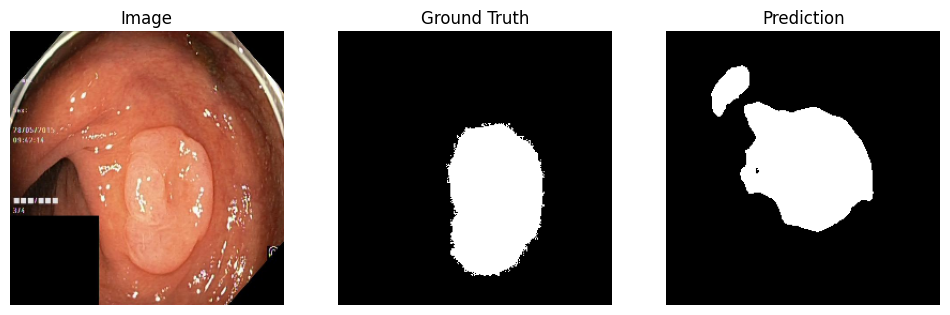

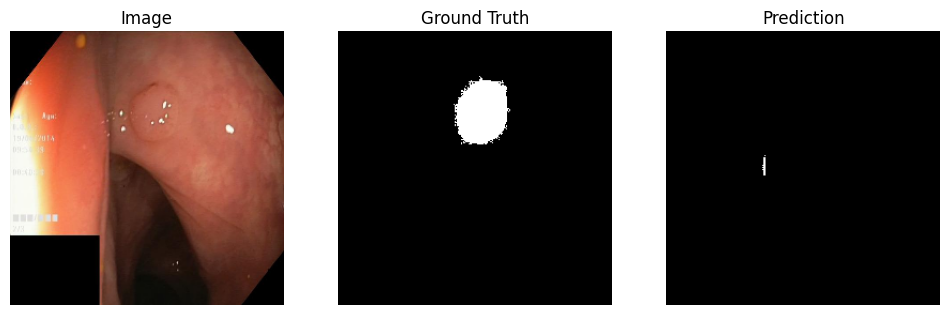

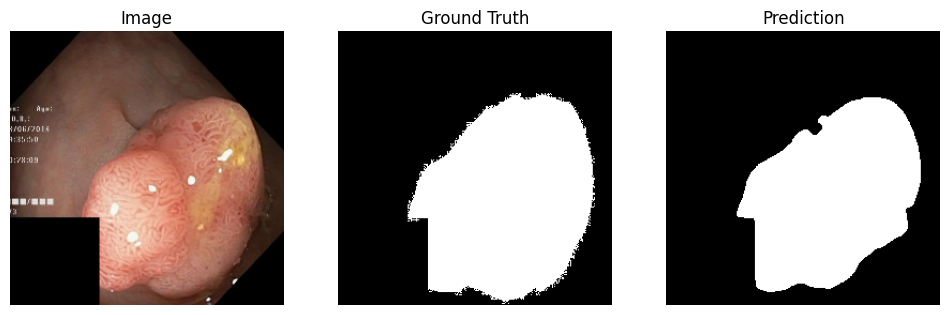

In [25]:
show_predictions(model, val_loader, device)